<a href="https://colab.research.google.com/github/SecrezS/MACDforecasting/blob/main/XLK_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Step 1: Import required libraries

In [ ]:
!pip install pycaret yellowbrick
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import pycaret
from pycaret.regression import *
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.linear_model import HuberRegressor
from sklearn.svm import SVR

# Download and extract the libta-lib binaries
url = 'https://anaconda.org/conda-forge/libta-lib/0.4.0/download/linux-64/libta-lib-0.4.0-h166bdaf_1.tar.bz2'
!curl -L $url | tar xj -C /usr/lib/x86_64-linux-gnu/ lib --strip-components=1

# Download and extract the Python wrapper for TA-Lib
url = 'https://anaconda.org/conda-forge/ta-lib/0.4.19/download/linux-64/ta-lib-0.4.19-py310hde88566_4.tar.bz2'
!curl -L $url | tar xj -C /usr/local/lib/python3.10/dist-packages/ lib/python3.10/site-packages/talib --strip-components=3

# Import TA-Lib
import talib

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4035    0  4035    0     0   9518      0 --:--:-- --:--:-- --:--:--  9539
100  517k  100  517k    0     0   509k      0  0:00:01  0:00:01 --:--:-- 2068k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4027    0  4027    0     0  11489      0 --:--:-- --:--:-- --:--:-- 11505
100  392k  100  392k    0     0   467k      0 --:--:-- --:--:-- --:--:-- 1943k


# Step 2: Download data and prepare main dataframe

In [ ]:
import yfinance as yf

#Load dataset

# Download data for multiple tickers (SPY, DIA, QQQ, IWM, XLK)
tickers = ["SPY", "DIA", "QQQ", "IWM", "XLK"]
dfs = {}

for ticker in tickers:
    # Download historical data without multi-index column names
    df = yf.download(ticker, start="2012-01-01", end="2024-01-01")
    df.reset_index(inplace=True)

    # Rename columns to remove multi-index formatting and ticker name
    df.columns = [col[0] if isinstance(col, tuple) else col for col in df.columns]

    # Store the cleaned DataFrame in the dictionary
    dfs[ticker] = df

# Choose the main dataset for demonstration, SPY
data = dfs["XLK"].copy()

data.head()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


,Date,Adj Close,Close,High,Low,Open,Volume
0,2012-01-03 00:00:00+00:00,21.622311,25.809999,26.020000,25.790001,25.870001,26839900
1,2012-01-04 00:00:00+00:00,21.680958,25.879999,25.930000,25.660000,25.799999,4744300
2,2012-01-05 00:00:00+00:00,21.747978,25.959999,26.010000,25.730000,25.850000,6756900
3,2012-01-06 00:00:00+00:00,21.756348,25.969999,26.030001,25.850000,25.980000,4989200
4,2012-01-09 00:00:00+00:00,21.722836,25.930000,26.080000,25.860001,26.059999,4086600


#Step 3: Adding features (technical indicators)

In [ ]:
# Calculate RSI
data['RSI'] = talib.RSI(data['Adj Close'], timeperiod=14)

# Calculate Moving Average Convergence Divergence (MACD)
data['MACD'], data['MACD_signal'], data['MACD_diff'] = talib.MACD(data['Adj Close'], fastperiod=12, slowperiod=26, signalperiod=9)

# Calculate Average True Range (ATR)
data['ATR'] = talib.ATR(data['High'], data['Low'], data['Adj Close'], timeperiod=14)

# Calculate Bollinger Bands (BB)
data['bb_bbm'], data['bb_bbh'], data['bb_bbl'] = talib.BBANDS(data['Adj Close'], timeperiod=20, nbdevup=2, nbdevdn=2, matype=0)

# Calculate Keltner Channel (KC)
data['EMA_KC'] = talib.EMA(data['Adj Close'], timeperiod=20)
data['KC_upper'] = data['EMA_KC'] + (data['ATR'] * 1.5)
data['KC_lower'] = data['EMA_KC'] - (data['ATR'] * 1.5)
data['KC'] = (data['Adj Close'] - data['KC_upper']) / data['Adj Close']
data.drop(columns=['EMA_KC', 'KC_upper', 'KC_lower'], inplace=True)

# Calculate Donchian Channel (DC)
data['DC_upper'] = data['High'].rolling(window=20).max()
data['DC_lower'] = data['Low'].rolling(window=20).min()
data['DC_middle'] = (data['DC_upper'] + data['DC_lower']) / 2

# Calculate On-Balance Volume (OBV)
data['OBV'] = talib.OBV(data['Adj Close'], data['Volume'])

# Calculate Chaikin Money Flow (CMF)
cmf_period = 20
data['Money_Flow_Multiplier'] = ((data['Adj Close'] - data['Low']) - (data['High'] - data['Adj Close'])) / (data['High'] - data['Low'])
data['Money_Flow_Volume'] = data['Money_Flow_Multiplier'] * data['Volume']
data['CMF'] = data['Money_Flow_Volume'].rolling(window=cmf_period).sum() / data['Volume'].rolling(window=cmf_period).sum()
data.drop(columns=['Money_Flow_Multiplier', 'Money_Flow_Volume'], inplace=True)

# Calculate the Stochastic Oscillator
data['stoch_k'], data['stoch_d'] = talib.STOCH(data['High'], data['Low'], data['Adj Close'],
                                               fastk_period=14,  # The %K period
                                               slowk_period=3,   # The %K slowing period
                                               slowk_matype=0,   # Moving average type for %K (0 = SMA)
                                               slowd_period=3,   # The %D period
                                               slowd_matype=0)   # Moving average type for %D (0 = SMA)

# Calculate the Average Directional Index (ADX)
data['ADX'] = talib.ADX(data['High'], data['Low'], data['Adj Close'], timeperiod=14)

# Number of lag days to create
lags = 20

# List of features to create lag features (exlcude "Adj Close")
features_to_lag = ['Volume', 'RSI', 'MACD', 'MACD_signal',
                   'MACD_diff', 'ATR', 'bb_bbm', 'bb_bbh',
                   'bb_bbl', 'KC','DC_upper', 'DC_lower',
                   'DC_middle','OBV','CMF','stoch_k','stoch_d','ADX']

# Function to create lagged features
def create_lagged_features(df, lags, columns):
    for col in columns:
        for lag in range(1, lags + 1):
            df[f'{col}_lag_{lag}'] = df[col].shift(lag)
    return df

# Apply lagged features
data = create_lagged_features(data, lags, features_to_lag)
data.dropna(inplace=True)

# Display the data to see the added lagged columns
data.head()

,Date,Adj Close,Close,High,Low,Open,Volume,RSI,MACD,MACD_signal,...,ADX_lag_11,ADX_lag_12,ADX_lag_13,ADX_lag_14,ADX_lag_15,ADX_lag_16,ADX_lag_17,ADX_lag_18,ADX_lag_19,ADX_lag_20
53,2012-03-20 00:00:00+00:00,25.272020,30.070000,30.110001,29.840000,29.920000,5713100,79.086419,0.498565,0.460674,...,59.961037,62.287484,62.859545,63.520825,64.232973,65.276805,66.700161,66.718622,67.027808,66.278047
54,2012-03-21 00:00:00+00:00,25.263613,30.059999,30.250000,30.049999,30.120001,8825000,78.694962,0.497402,0.468019,...,56.218064,59.961037,62.287484,62.859545,63.520825,64.232973,65.276805,66.700161,66.718622,67.027808
55,2012-03-22 00:00:00+00:00,25.204786,29.990000,30.070000,29.879999,29.930000,7500900,75.865450,0.486130,0.471641,...,53.374805,56.218064,59.961037,62.287484,62.859545,63.520825,64.232973,65.276805,66.700161,66.718622
56,2012-03-23 00:00:00+00:00,25.204786,29.990000,30.040001,29.830000,30.040001,9511600,75.865450,0.471759,0.471665,...,51.594630,53.374805,56.218064,59.961037,62.287484,62.859545,63.520825,64.232973,65.276805,66.700161
57,2012-03-26 00:00:00+00:00,25.574581,30.430000,30.440001,30.120001,30.190001,12187200,80.877971,0.484622,0.474256,...,50.185142,51.594630,53.374805,56.218064,59.961037,62.287484,62.859545,63.520825,64.232973,65.276805


#Step 4: Data Cleaning

In [ ]:
#Drop Non-Lagged Technical Indicator

# Define the target column
target_column = 'Adj Close'

# List of non-lagged technical indicators to drop
non_lagged_technical_indicators = [
    'RSI', 'MACD', 'MACD_signal', 'MACD_diff', 'ATR', 'bb_bbm', 'bb_bbh', 'bb_bbl',
    'KC', 'DC_upper', 'DC_lower', 'DC_middle', 'OBV', 'CMF', 'ADX', 'stoch_k', 'stoch_d'
]

# Drop non-lagged columns and other unwanted columns
columns_to_drop = ['Open', 'High', 'Low', 'Close', 'Volume'] + non_lagged_technical_indicators
data = data.drop(columns=columns_to_drop, errors='ignore')

#Step 5: Create features and target variables

In [ ]:
# Convert the 'Date' column to datetime format if it's not already
data['Date'] = pd.to_datetime(data['Date'])

# Set 'Date' as the index
data.set_index('Date', inplace=True)

# Split into training, validation, and test sets
train_data = data[data.index < "2022-01-01"]
validation_data = data[(data.index >= "2022-01-01") & (data.index < "2023-01-01")]
test_data = data[data.index >= "2023-01-01"]

# Display the sizes of each set to ensure proper segregation
print(f"Training set: {train_data.shape}")
print(f"Validation set: {validation_data.shape}")
print(f"Test set: {test_data.shape}")

Training set: (2464, 361)
Validation set: (251, 361)
Test set: (250, 361)


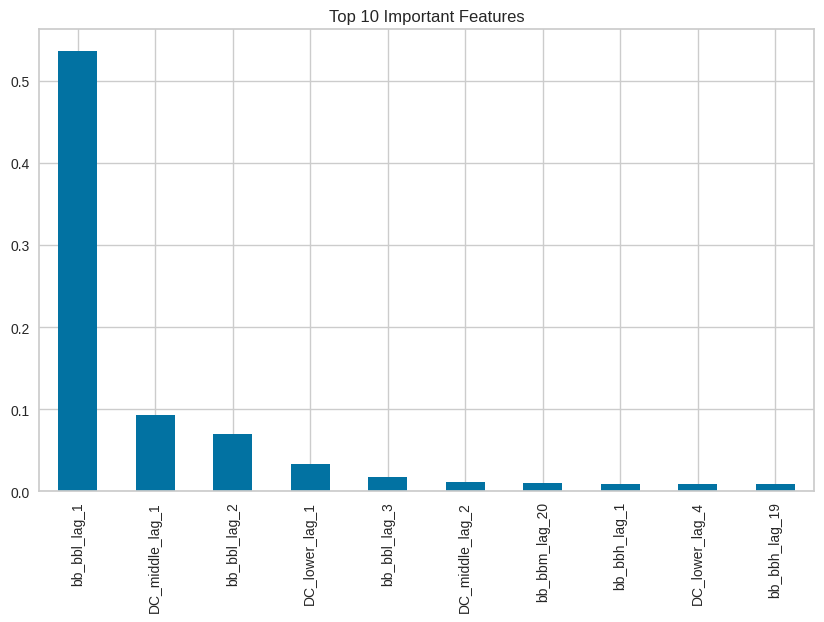

['bb_bbl_lag_1',
 'DC_middle_lag_1',
 'bb_bbl_lag_2',
 'DC_lower_lag_1',
 'bb_bbl_lag_3',
 'DC_middle_lag_2',
 'bb_bbm_lag_20',
 'bb_bbh_lag_1',
 'DC_lower_lag_4',
 'bb_bbh_lag_19',
 'bb_bbm_lag_19',
 'bb_bbh_lag_20',
 'DC_upper_lag_1',
 'bb_bbm_lag_1',
 'bb_bbm_lag_2',
 'bb_bbh_lag_2',
 'bb_bbm_lag_4',
 'bb_bbm_lag_3',
 'bb_bbh_lag_3',
 'bb_bbm_lag_5',
 'DC_middle_lag_4']

In [ ]:
# Features and target for training
X_train = train_data.drop(columns=['Adj Close'])
y_train = train_data['Adj Close']

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Identify important features (features with importance > 0.005, contributes at least 0.5% to the model's predictive ability)
feature_importances = pd.Series(rf_model.feature_importances_, index=X_train.columns).sort_values(ascending=False)
selected_features = feature_importances[feature_importances > 0.005].index.tolist()

# Plot the top 10 important features
plt.figure(figsize=(10, 6))
feature_importances.head(10).plot(kind='bar')
plt.title('Top 10 Important Features')
plt.show()

# Show the selected features
selected_features

In [ ]:
# Use only the selected features
train_data_selected = train_data[selected_features + ['Adj Close']]
validation_data_selected = validation_data[selected_features + ['Adj Close']]
test_data_selected = test_data[selected_features + ['Adj Close']]

#Step 7: Scaling the data

In [ ]:
# Separate features and target in each dataset
X_train = train_data_selected[selected_features]
y_train = train_data_selected[['Adj Close']]

X_val = validation_data_selected[selected_features]
y_val = validation_data_selected[['Adj Close']]

X_test = test_data_selected[selected_features]
y_test = test_data_selected[['Adj Close']]

# Instantiate scalers
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

# Fit the scalers on the training data, then transform all datasets
X_train_scaled = scaler_X.fit_transform(X_train)
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))

X_val_scaled = scaler_X.transform(X_val)
y_val_scaled = scaler_y.transform(y_val.values.reshape(-1, 1))

X_test_scaled = scaler_X.transform(X_test)
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))

# Reshape for LSTM input (only on X datasets)
X_train_scaled = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_val_scaled = X_val_scaled.reshape((X_val_scaled.shape[0], 1, X_val_scaled.shape[1]))
X_test_scaled = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

#Step 8: Build and Train the LSTM Model

In [ ]:
# Define the LSTM model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(1, X_train_scaled.shape[2])),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(25),
    Dense(1)  # Output layer for prediction
])

model.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with validation data and early stopping (optional)
model.fit(
    X_train_scaled,
    y_train_scaled,
    epochs=50,
    batch_size=32,
    validation_data=(X_val_scaled, y_val_scaled),  # Optional: monitor validation loss
    callbacks=[early_stopping]  # Optional: apply early stopping
)

Epoch 1/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.0355 - val_loss: 0.0025
Epoch 2/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0023 - val_loss: 0.0041
Epoch 3/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0023 - val_loss: 0.0022
Epoch 4/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0018 - val_loss: 0.0066
Epoch 5/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0015 - val_loss: 0.0023
Epoch 6/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0016 - val_loss: 0.0030
Epoch 7/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0013 - val_loss: 0.0039
Epoch 8/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0013 - val_loss: 0.0028


In [ ]:
# Evaluate on the test set
test_loss = model.evaluate(X_test_scaled, y_test_scaled)
print("Test Loss (MSE):", test_loss)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0037
Test Loss (MSE): 0.00471503846347332


In [ ]:
# Make predictions on the test set
y_pred_scaled = model.predict(X_test_scaled)

# Inverse transform the predictions and the true values
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_test_actual = scaler_y.inverse_transform(y_test_scaled)


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step


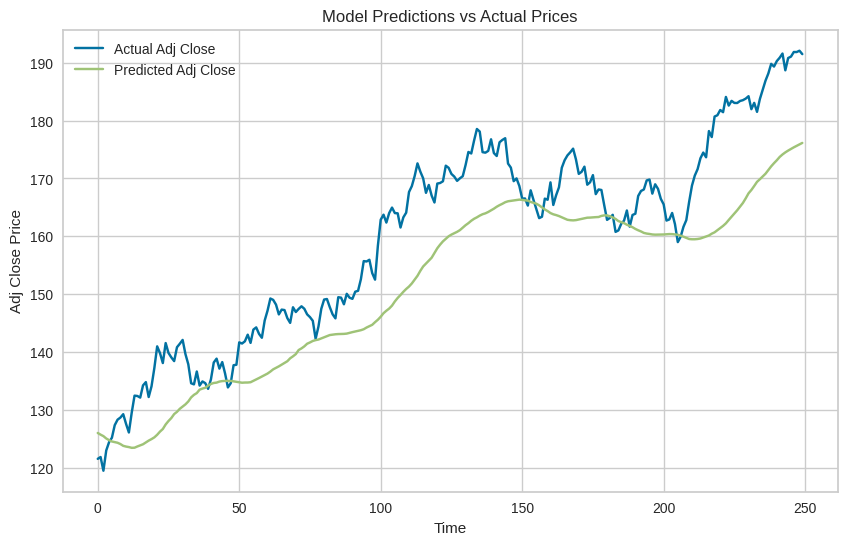

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(y_test_actual, label='Actual Adj Close')
plt.plot(y_pred, label='Predicted Adj Close')
plt.xlabel('Time')
plt.ylabel('Adj Close Price')
plt.legend()
plt.title("Model Predictions vs Actual Prices")
plt.show()


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
import numpy as np

rmse = np.sqrt(mean_squared_error(y_test_actual, y_pred))
mae = mean_absolute_error(y_test_actual, y_pred)
mape = mean_absolute_percentage_error(y_test_actual, y_pred)

print("RMSE:", rmse)
print("MAE:", mae)
print("MAPE:", mape)
print("r2_score", r2_score(y_test_actual, y_pred))

RMSE: 10.277172530953342
MAE: 8.694775329589845
MAPE: 0.05303873812014997
r2_score 0.6599194799295344


In [ ]:
# List of tickers
tickers = ["SPY", "DIA", "QQQ", "IWM", "XLK"]
dfs = {}

for ticker in tickers:
    # Download historical data starting from 2024-01-01 for each ticker
    df = yf.download(ticker, start="2024-01-01")
    df.reset_index(inplace=True)

    # Rename columns to standardize format without ticker name
    df.columns = ['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']

    # Store the cleaned DataFrame in the dictionary
    dfs[ticker] = df

# Use XLK data after 2024-01-01 for further processing
new_data = dfs["XLK"].copy()

new_data.head()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


,Date,Open,High,Low,Close,Adj Close,Volume
0,2024-01-02 00:00:00+00:00,186.468338,187.440002,190.160004,186.250000,189.860001,11772700
1,2024-01-03 00:00:00+00:00,184.568237,185.529999,186.750000,185.199997,185.729996,9095000
2,2024-01-04 00:00:00+00:00,183.215271,184.169998,185.669998,183.990005,184.389999,6063600
3,2024-01-05 00:00:00+00:00,183.165543,184.119995,185.710007,183.419998,184.380005,8173600
4,2024-01-08 00:00:00+00:00,187.761581,188.740005,188.869995,184.860001,185.050003,8217300


In [ ]:
new_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210 entries, 0 to 209
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype              
---  ------     --------------  -----              
 0   Date       210 non-null    datetime64[ns, UTC]
 1   Open       210 non-null    float64            
 2   High       210 non-null    float64            
 3   Low        210 non-null    float64            
 4   Close      210 non-null    float64            
 5   Adj Close  210 non-null    float64            
 6   Volume     210 non-null    int64              
dtypes: datetime64[ns, UTC](1), float64(5), int64(1)
memory usage: 11.6 KB


In [ ]:
import pandas as pd
import numpy as np
import talib as ta  # If you used TA-Lib for the indicators

# Calculate Bollinger Bands and Donchian Channels (example for bb_bbl, bb_bbm, and DC_middle)
new_data['bb_bbl'], new_data['bb_bbm'], new_data['bb_bbh'] = ta.BBANDS(
    new_data['Close'], timeperiod=20, nbdevup=2, nbdevdn=2, matype=0)

new_data['DC_upper'] = new_data['High'].rolling(window=20).max()
new_data['DC_lower'] = new_data['Low'].rolling(window=20).min()
new_data['DC_middle'] = (new_data['DC_upper'] + new_data['DC_lower']) / 2

# Create lags for each feature as in your original setup
lag_features = ['bb_bbl', 'bb_bbm', 'bb_bbh', 'DC_middle', 'DC_lower', 'DC_upper']
for feature in lag_features:
    for lag in range(1, 21):  # Adjust lag range based on original features
        new_data[f'{feature}_lag_{lag}'] = new_data[feature].shift(lag)

# Drop any rows with NaN values caused by lagging or indicator calculation
new_data = new_data.dropna()


In [ ]:
# Select only the required lagged features
selected_features = [
    'bb_bbl_lag_1', 'DC_middle_lag_1', 'bb_bbl_lag_2', 'DC_lower_lag_1', 'bb_bbl_lag_3',
    'DC_middle_lag_2', 'bb_bbm_lag_20', 'bb_bbh_lag_1', 'DC_lower_lag_4', 'bb_bbh_lag_19',
    'bb_bbm_lag_19', 'bb_bbh_lag_20', 'DC_upper_lag_1', 'bb_bbm_lag_1', 'bb_bbm_lag_2',
    'bb_bbh_lag_2', 'bb_bbm_lag_4', 'bb_bbm_lag_3', 'bb_bbh_lag_3', 'bb_bbm_lag_5',
    'DC_middle_lag_4'
]
new_data_selected = new_data[selected_features]

# Scale the new data using the previously fitted scaler
new_data_scaled = scaler_X.transform(new_data_selected)

# Reshape for LSTM model compatibility
new_data_scaled = new_data_scaled.reshape((new_data_scaled.shape[0], 1, new_data_scaled.shape[1]))


In [ ]:
# Generate predictions
predictions_scaled = model.predict(new_data_scaled)

# Inverse transform to obtain predictions in the original scale
predictions = scaler_y.inverse_transform(predictions_scaled)

# Display the predicted "Adj Close" prices for the future dates
print("Predicted 'Adj Close' prices for XLK from 2024 onwards:", predictions)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Predicted 'Adj Close' prices for XLK from 2024 onwards: [[188.7393 ]
 [188.29451]
 [187.91939]
 [187.60643]
 [187.37776]
 [187.19427]
 [186.97937]
 [186.73297]
 [186.51   ]
 [186.34422]
 [186.20003]
 [186.10063]
 [186.03604]
 [185.87047]
 [185.75444]
 [185.69916]
 [185.64691]
 [185.6963 ]
 [185.71085]
 [185.87793]
 [186.32172]
 [186.64095]
 [186.96489]
 [187.45161]
 [187.76552]
 [188.05278]
 [188.34825]
 [188.69911]
 [189.36322]
 [189.7296 ]
 [189.91328]
 [190.38554]
 [190.64766]
 [190.93326]
 [191.1684 ]
 [191.55081]
 [192.12813]
 [192.53389]
 [193.04584]
 [193.67113]
 [194.10251]
 [194.5382 ]
 [194.97319]
 [195.33081]
 [195.69176]
 [196.0679 ]
 [196.47662]
 [196.8617 ]
 [197.30562]
 [197.71303]
 [198.36319]
 [198.91275]
 [199.40337]
 [200.0809 ]
 [200.76167]
 [201.49065]
 [201.7823 ]
 [202.14243]
 [202.5949 ]
 [202.6753 ]
 [202.6818 ]
 [202.54182]
 [202.48457]
 [202.49109]
 [202.25961]
 [201.98888]
 [201.94276]
 [201.88551]
 [201.54633]
 [201.441

In [ ]:
import pandas as pd

# Ensure predictions have the same index as new_data after dropping NaN values
comparison_df = pd.DataFrame({
    'Date': new_data['Date'].values,  # Dates in new_data
    'Actual Adj Close': new_data['Adj Close'].values,  # Actual prices
    'Predicted Adj Close': predictions.flatten()  # Flatten to ensure 1D array
})

# Display the comparison table
comparison_df.set_index('Date', inplace=True)  # Set Date as index for better readability
print(comparison_df.head())


            Actual Adj Close  Predicted Adj Close
Date                                             
2024-04-23        195.059998           188.739304
2024-04-24        198.589996           188.294510
2024-04-25        195.559998           187.919388
2024-04-26        199.160004           187.606430
2024-04-29        200.860001           187.377762


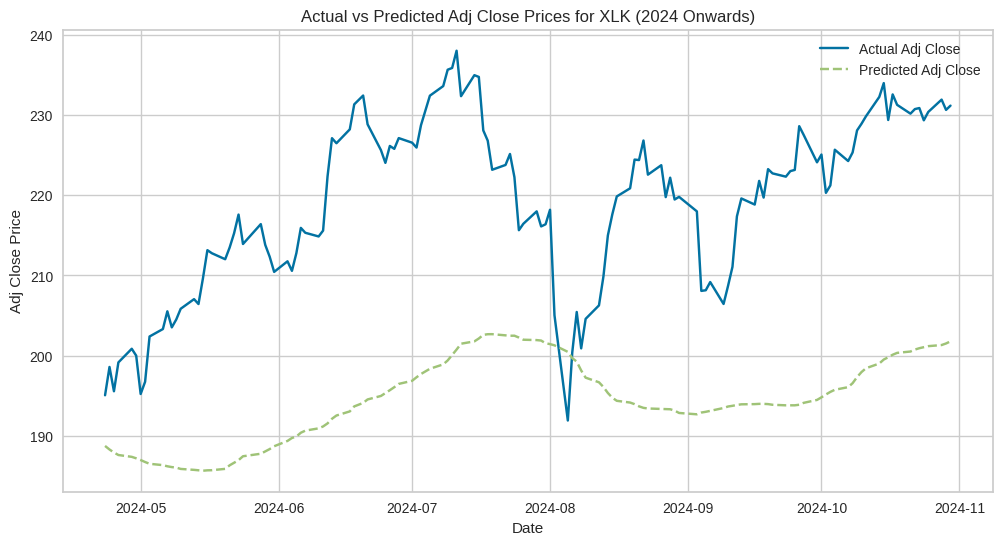

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(comparison_df.index, comparison_df['Actual Adj Close'], label='Actual Adj Close')
plt.plot(comparison_df.index, comparison_df['Predicted Adj Close'], label='Predicted Adj Close', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Adj Close Price')
plt.title('Actual vs Predicted Adj Close Prices for XLK (2024 Onwards)')
plt.legend()
plt.show()


#Step 9: Make Predictions

In [ ]:
# Make predictions on the test set
predictions = model.predict(X_test_scaled)

# Inverse scaling of the predictions
predictions = scaler_y.inverse_transform(predictions)

# Inverse scaling of the actual target values for comparison
y_test = scaler_y.inverse_transform(y_test_scaled)


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step


#Step 10: Evaluate the model

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error,r2_score

# Existing metrics
rmse = np.sqrt(mean_squared_error(y_test, predictions))
mae = mean_absolute_error(y_test, predictions)
mape = mean_absolute_percentage_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

# Display the results
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Absolute Percentage Error (MAPE): {mape}")
print(f"R² Score: {r2}")


Root Mean Squared Error (RMSE): 15.921266509196132
Mean Absolute Error (MAE): 14.298933502197261
Mean Absolute Percentage Error (MAPE): 0.08629536426783967
R² Score: 0.1838129702095712


#Step 11: Plot the Predictions

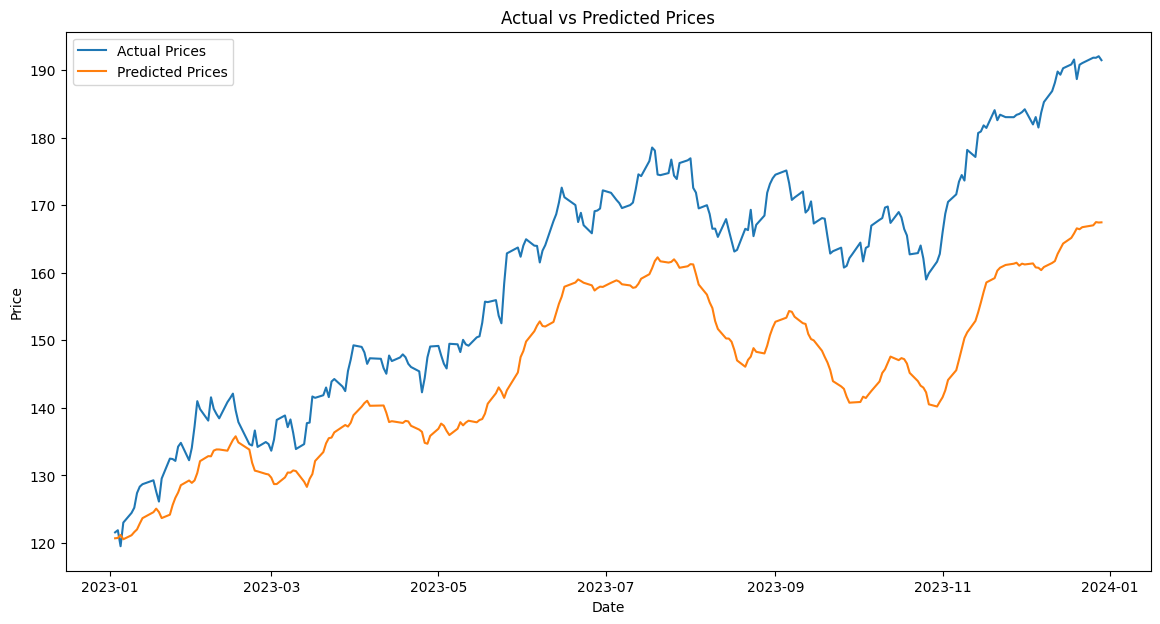

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))
plt.plot(test_data.index, y_test, label='Actual Prices')
plt.plot(test_data.index, predictions, label='Predicted Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Actual vs Predicted Prices')
plt.legend()
plt.show()